### Imports

In [1]:
import random
from typing import Union

import numpy as np
import pandas as pd
from imblearn.over_sampling import *
from IPython.display import display
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import seaborn as sns

/home/proven_warrior/hse/first_year_project/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Constants

In [2]:
DATASET_PATH = "scaled_myocardial_infarction_dataset.csv"
SEED = 0
MAX_ITER = 1000

In [3]:
np.random.seed(SEED)
random.seed(SEED)

### Dataset Loading 

In [4]:
infarction_df = pd.read_csv(DATASET_PATH)
infarction_df.head(5)

,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,GB,SIM_GIPERT,DLIT_AG,ZSN_A,...,JELUD_TAH,FIBR_JELUD,A_V_BLOK,OTEK_LANC,RAZRIV,DRESSLER,ZSN,REC_IM,P_IM_STEN,LET_IS
0,0.8750,0.0,2.0,0.0,-0.5,1.0,0.5,0.0,0.857143,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.5000,0.0,1.0,-0.2,-1.0,-1.0,-1.0,0.0,-0.142857,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.6875,0.0,0.0,-0.2,-1.0,1.0,0.0,0.0,0.142857,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.3125,-1.0,0.0,-0.2,-1.0,1.0,0.0,0.0,0.285714,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-0.1875,0.0,0.0,-0.2,-1.0,1.0,0.5,0.0,0.857143,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
numeric_columns = [
    "AGE",
    "S_AD_KBRIG",
    "D_AD_KBRIG",
    "S_AD_ORIT",
    "D_AD_ORIT",
    "K_BLOOD",
    "NA_BLOOD",
    "ALT_BLOOD",
    "AST_BLOOD",
    "L_BLOOD",
    "ROE",
]

target_columns = [
    "FIBR_PREDS",
    "PREDS_TAH",
    "JELUD_TAH",
    "FIBR_JELUD",
    "A_V_BLOK",
    "OTEK_LANC",
    "RAZRIV",
    "DRESSLER",
    "ZSN",
    "REC_IM",
    "P_IM_STEN",
    "LET_IS",
]

categorical_columns = []
for col in infarction_df.columns:
    if col not in numeric_columns and col not in target_columns:
        categorical_columns.append(col)

We preprocessed our data during the Checkpoint 3, so the only thing that remains is to test the various ML-models for predicting the targets.

As authors of the Dataset pointed out, it's possible to tackle multiple tasks regarding the dataset. There are __four__ possible time moments for __complication prediction__: on base of the information known at:
- __the time of admission to hospital__: all input columns (2-112) except 93, 94, 95, 100, 101, 102, 103, 104, 105 can be used for prediction;
- __the end of the first day__ (24 hours after admission to the hospital): all input columns (2-112) except 94, 95, 101, 102, 104, 105 can be used for prediction;
- __the end of the second day__ (48 hours after admission to the hospital) all input columns (2-112) except 95, 102, 105 can be used for prediction;
- __the end of the third day__ (72 hours after admission to the hospital) all input columns (2-112) can be used for prediction.

In this notebook we'll try to solve the task of predicting targets on __the time of admission to hospital__. 

Thus, we should get rid of columns numbered 93, 94, 95, 100, 101, 102, 103, 104, 105.

More info about the features can be found in _Checkpoint 3 EDA_ notebook, as well as in _Checkpoint 2_ Markdown file.

In [6]:
columns_to_drop = [
    "R_AB_1_n",
    "R_AB_2_n",
    "R_AB_3_n",
    "NA_R_1_n",
    "NA_R_2_n",
    "NA_R_3_n",
    "NOT_NA_1_n",
    "NOT_NA_2_n",
    "NOT_NA_3_n",
]

infarction_df.drop(columns=columns_to_drop, inplace=True)
for col_to_drop in columns_to_drop:
    if col_to_drop in categorical_columns:
        categorical_columns.remove(col_to_drop)

It's important to note that the task at hand is __multilabel__ classification.

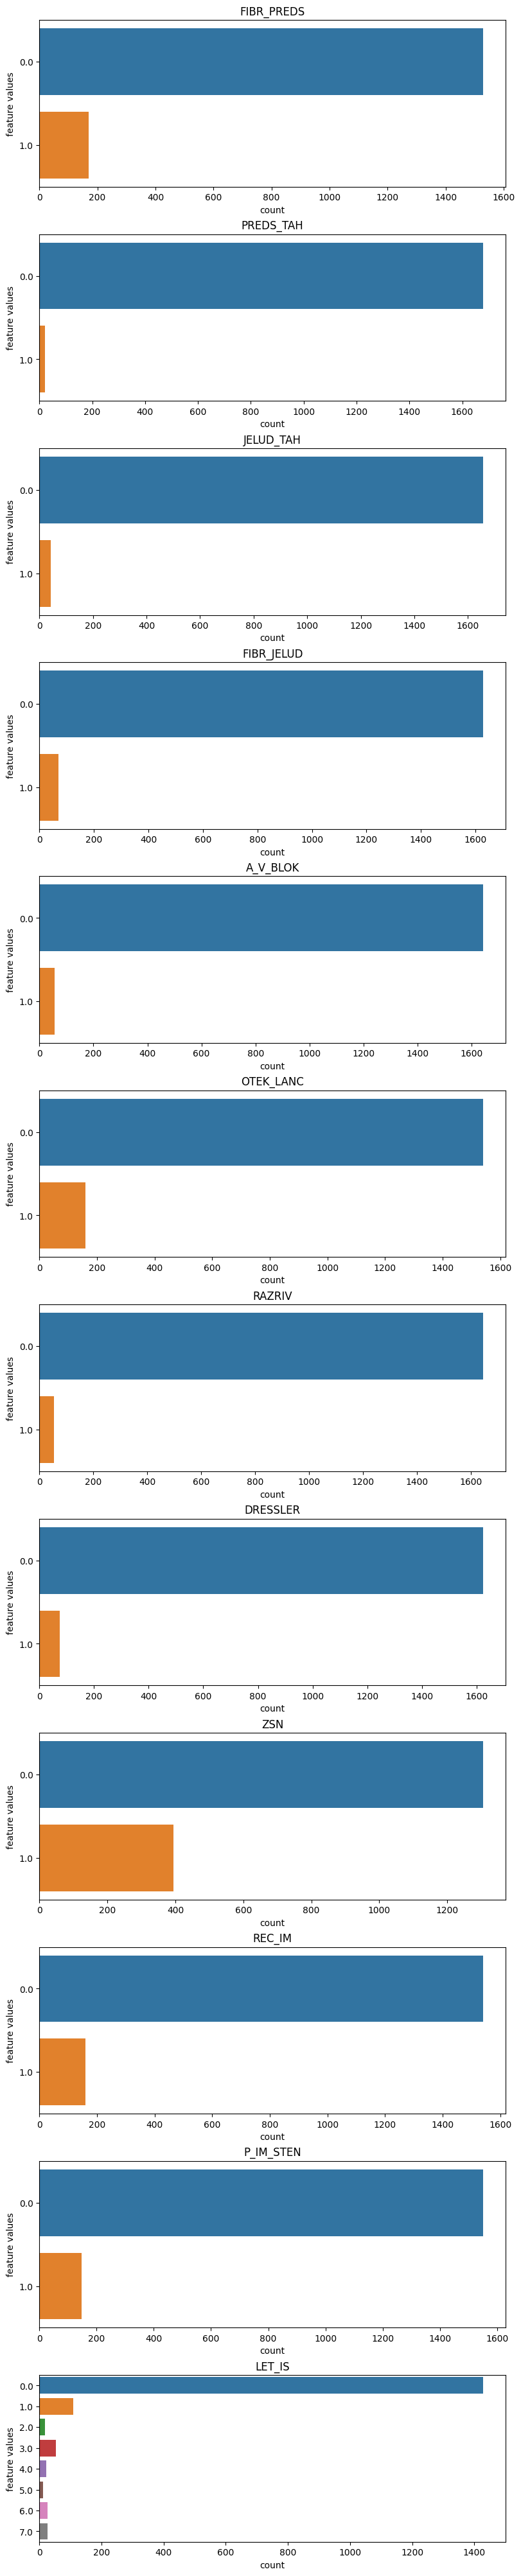

In [7]:
fig, axes = plt.subplots(nrows=len(target_columns), ncols=1, figsize=(8, 40), constrained_layout=True)
for idx, target in enumerate(target_columns):
    sns.countplot(y=infarction_df[target], ax=axes[idx])
    axes[idx].set_ylabel("feature values")
    axes[idx].set_title(target)

Most of the targets are binary, only the last one `LET_IS` needs special treatment.

### Metric

The `F1-score` seems like a good idea for such task given that we have a multiclass target `LET_IS` (we would use averaging methods to show how they react to given predictions from model), as well as due to the fact that the targets are highly imbalanced and we need to account for this. At the same time, `Recall` will be of main focus because of the task at hand (medical dataset, more on it in later cells).

As for how we would structure our learning phase - it's quite simple, actually. Train a distinct models on the dataset each for one target and append their results in the end (convert multilabel to binary classification in most of the cases except for target `LET_IS` (multiclass classification)).

### Linear Models

We'll use __Logistic Regression__ as one of the most reliable algorithms from Linear models familty.

##### Standard Logistic Regression

The dataset will be split into training and validating portions. Scores will be calculated for Validation portion of the dataset. Cross validation won't be used given the small portion of positive objects in the dataset. 

Through some testing it was confirmed that cross validation produced far better scores compared to the real validation scores (overestimated the results and didn't paint an honest picture).

In [8]:
def calculate_scores(
    y_true,
    y_pred,
    scorers: list,
    target_name: str,
    resample_technique_name: Union[None, str] = None,
    average_method: Union[None, str] = None,
    round_score_by: int = 4,
    verbose: bool = True,
):
    scorers_names = []
    scores = []
    print(f"Target = {target_name}")
    for scorer in scorers:
        if average_method is not None:
            score = scorer(
                y_true=y_true, y_pred=y_pred, average=average_method, zero_division=0
            )
        else:
            score = scorer(y_true=y_true, y_pred=y_pred, zero_division=0)
        if resample_technique_name is not None:
            score_name = (
                f"{resample_technique_name} - {target_name} - {scorer.__name__}"
            )
        else:
            score_name = f"{target_name} - {scorer.__name__}"
        if verbose:
            print(f"{score_name}: ", round(score, round_score_by))
        scores.append(score)
        scorers_names.append(score_name)

    return pd.DataFrame({"Metric name": scorers_names, "Score": scores})

In [54]:
def train_log_reg(
    X: pd.DataFrame,
    y: pd.Series,
    target_name: str,
    resampler=None,
    params: dict = None,
    verbose_metrics: bool = True,
):
    X_train, X_eval, y_train, y_eval = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=SEED
    )
    if params is not None:
        log = LogisticRegression(**params, max_iter=MAX_ITER, random_state=SEED)
    else:
        log = LogisticRegression(max_iter=MAX_ITER, random_state=SEED)
    if resampler is not None:
        X_train, y_train = resampler.fit_resample(X_train, y_train)
    log.fit(X_train, y_train)
    if target_name != "LET_IS":
        average = "binary"
    else:
        average = "micro"
    preds = log.predict(X_eval)
    if resampler is not None:
        cur_metrics = calculate_scores(
            y_eval,
            preds,
            [f1_score, recall_score, precision_score],
            target_name,
            resampler.__class__.__name__,
            average_method=average,
            verbose=verbose_metrics,
        )
    else:
        cur_metrics = calculate_scores(
            y_eval,
            preds,
            [f1_score, recall_score, precision_score],
            target_name,
            average_method=average,
            verbose=verbose_metrics,
        )
    return cur_metrics

Let's try and just train Logistic Regressions with standard parameters.

In [10]:
X = infarction_df[numeric_columns + categorical_columns]

In [11]:
for target in target_columns:
    train_log_reg(X, infarction_df[target], target)

Target = FIBR_PREDS
FIBR_PREDS - f1_score:  0.1364
FIBR_PREDS - recall_score:  0.0882
FIBR_PREDS - precision_score:  0.3
Target = PREDS_TAH
PREDS_TAH - f1_score:  0.0
PREDS_TAH - recall_score:  0.0
PREDS_TAH - precision_score:  0.0
Target = JELUD_TAH
JELUD_TAH - f1_score:  0.0
JELUD_TAH - recall_score:  0.0
JELUD_TAH - precision_score:  0.0
Target = FIBR_JELUD
FIBR_JELUD - f1_score:  0.0
FIBR_JELUD - recall_score:  0.0
FIBR_JELUD - precision_score:  0.0
Target = A_V_BLOK
A_V_BLOK - f1_score:  0.1429
A_V_BLOK - recall_score:  0.0909
A_V_BLOK - precision_score:  0.3333
Target = OTEK_LANC
OTEK_LANC - f1_score:  0.1026
OTEK_LANC - recall_score:  0.0625
OTEK_LANC - precision_score:  0.2857
Target = RAZRIV
RAZRIV - f1_score:  0.0
RAZRIV - recall_score:  0.0
RAZRIV - precision_score:  0.0
Target = DRESSLER
DRESSLER - f1_score:  0.0
DRESSLER - recall_score:  0.0
DRESSLER - precision_score:  0.0
Target = ZSN
ZSN - f1_score:  0.1702
ZSN - recall_score:  0.1013
ZSN - precision_score:  0.5333
Targ

We encounter one of the most typical problems of working with Medical Data: our __recall is exceptionally low__. That's mainly due to the fact that we have little samples with positive class for each of targets and model can't really distinguish them from the total number of the samples.

##### Using Over-Sampling with Logistic Regression

Let's try to use some over-sampling techniques in order to battle this issue. 

For this we'll use the module `imblearn`. We'll test the possible over-sampling algorithms to find the one which has the best `Recall` and `F1-score`.

Why `Recall` and not `Precision`? For our task, and for medical purposes in general, it's always better to have higher `Recall` score - we don't want to miss any possible patient with a disease, even if we'll have more _False Positives_.

In [12]:
categorical_features_indices = []
for idx, col in enumerate(X.columns):
    if col in categorical_columns:
        categorical_features_indices.append(idx)

In [13]:
metrics_results_for_samplers = []
for sampler in [
    RandomOverSampler,
    SMOTE,
    SMOTENC,
    ADASYN,
    BorderlineSMOTE,
    SVMSMOTE,
    KMeansSMOTE,
]:
    if sampler == SMOTENC:
        resampler = sampler(
            random_state=SEED, categorical_features=categorical_features_indices
        )
    else:
        resampler = sampler(random_state=SEED)
        for target in target_columns:
            try:
                metrics_results_for_samplers.append(
                    train_log_reg(
                        X=X,
                        y=infarction_df[target],
                        target_name=target,
                        resampler=resampler,
                    )
                )
            except RuntimeError:
                print(f"Could not use {sampler} algorithm")

Target = FIBR_PREDS
RandomOverSampler - FIBR_PREDS - f1_score:  0.3459
RandomOverSampler - FIBR_PREDS - recall_score:  0.6765
RandomOverSampler - FIBR_PREDS - precision_score:  0.2323
Target = PREDS_TAH
RandomOverSampler - PREDS_TAH - f1_score:  0.0
RandomOverSampler - PREDS_TAH - recall_score:  0.0
RandomOverSampler - PREDS_TAH - precision_score:  0.0
Target = JELUD_TAH
RandomOverSampler - JELUD_TAH - f1_score:  0.0714
RandomOverSampler - JELUD_TAH - recall_score:  0.25
RandomOverSampler - JELUD_TAH - precision_score:  0.0417
Target = FIBR_JELUD
RandomOverSampler - FIBR_JELUD - f1_score:  0.169
RandomOverSampler - FIBR_JELUD - recall_score:  0.4286
RandomOverSampler - FIBR_JELUD - precision_score:  0.1053
Target = A_V_BLOK
RandomOverSampler - A_V_BLOK - f1_score:  0.209
RandomOverSampler - A_V_BLOK - recall_score:  0.6364
RandomOverSampler - A_V_BLOK - precision_score:  0.125
Target = OTEK_LANC
RandomOverSampler - OTEK_LANC - f1_score:  0.2764
RandomOverSampler - OTEK_LANC - recall_sc

Target = RAZRIV
SVMSMOTE - RAZRIV - f1_score:  0.2162
SVMSMOTE - RAZRIV - recall_score:  0.3636
SVMSMOTE - RAZRIV - precision_score:  0.1538
Target = DRESSLER
SVMSMOTE - DRESSLER - f1_score:  0.1194
SVMSMOTE - DRESSLER - recall_score:  0.2667
SVMSMOTE - DRESSLER - precision_score:  0.0769
Target = ZSN
SVMSMOTE - ZSN - f1_score:  0.3871
SVMSMOTE - ZSN - recall_score:  0.4557
SVMSMOTE - ZSN - precision_score:  0.3364
Target = REC_IM
SVMSMOTE - REC_IM - f1_score:  0.2151
SVMSMOTE - REC_IM - recall_score:  0.3125
SVMSMOTE - REC_IM - precision_score:  0.1639
Target = P_IM_STEN
SVMSMOTE - P_IM_STEN - f1_score:  0.22
SVMSMOTE - P_IM_STEN - recall_score:  0.3667
SVMSMOTE - P_IM_STEN - precision_score:  0.1571
Target = LET_IS
SVMSMOTE - LET_IS - f1_score:  0.7912
SVMSMOTE - LET_IS - recall_score:  0.7912
SVMSMOTE - LET_IS - precision_score:  0.7912


/home/proven_warrior/hse/first_year_project/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Could not use <class 'imblearn.over_sampling._smote.cluster.KMeansSMOTE'> algorithm


/home/proven_warrior/hse/first_year_project/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Could not use <class 'imblearn.over_sampling._smote.cluster.KMeansSMOTE'> algorithm


/home/proven_warrior/hse/first_year_project/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Could not use <class 'imblearn.over_sampling._smote.cluster.KMeansSMOTE'> algorithm


/home/proven_warrior/hse/first_year_project/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Could not use <class 'imblearn.over_sampling._smote.cluster.KMeansSMOTE'> algorithm


/home/proven_warrior/hse/first_year_project/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Could not use <class 'imblearn.over_sampling._smote.cluster.KMeansSMOTE'> algorithm


/home/proven_warrior/hse/first_year_project/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Could not use <class 'imblearn.over_sampling._smote.cluster.KMeansSMOTE'> algorithm


/home/proven_warrior/hse/first_year_project/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Could not use <class 'imblearn.over_sampling._smote.cluster.KMeansSMOTE'> algorithm


/home/proven_warrior/hse/first_year_project/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Could not use <class 'imblearn.over_sampling._smote.cluster.KMeansSMOTE'> algorithm


/home/proven_warrior/hse/first_year_project/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Could not use <class 'imblearn.over_sampling._smote.cluster.KMeansSMOTE'> algorithm


/home/proven_warrior/hse/first_year_project/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Could not use <class 'imblearn.over_sampling._smote.cluster.KMeansSMOTE'> algorithm


/home/proven_warrior/hse/first_year_project/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Could not use <class 'imblearn.over_sampling._smote.cluster.KMeansSMOTE'> algorithm


/home/proven_warrior/hse/first_year_project/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/proven_warrior/hse/first_year_project/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Could not use <class 'imblearn.over_sampling._smote.cluster.KMeansSMOTE'> algorithm


In [29]:
samplers = metrics_for_oversampling["Metric name"].str.split(" - ").str[0]
targets = metrics_for_oversampling["Metric name"].str.split(" - ").str[1]
scorers = metrics_for_oversampling["Metric name"].str.split(" - ").str[2]
metrics_for_oversampling["Sampler"] = samplers
metrics_for_oversampling["Target"] = targets
metrics_for_oversampling["Metric"] = scorers

In [30]:
best_metrics = []
for target in target_columns:
    metrics_target = metrics_for_oversampling[
        metrics_for_oversampling["Target"] == target
    ]
    for metric in ["f1_score", "recall_score", "precision_score"]:
        metric_target = metrics_target[metrics_target["Metric"] == metric]
        best_metrics.append(
            metric_target.sort_values("Score", ascending=False)
            .iloc[0, :]
            .values.tolist()
        )

In [31]:
best_metrics_oversampling_df = pd.DataFrame(best_metrics)
best_metrics_oversampling_df.head(5)

,0,1,2,3,4
0,SVMSMOTE - FIBR_PREDS - f1_score,0.383838,SVMSMOTE,FIBR_PREDS,f1_score
1,RandomOverSampler - FIBR_PREDS - recall_score,0.676471,RandomOverSampler,FIBR_PREDS,recall_score
2,SVMSMOTE - FIBR_PREDS - precision_score,0.292308,SVMSMOTE,FIBR_PREDS,precision_score
3,RandomOverSampler - PREDS_TAH - f1_score,0.000000,RandomOverSampler,PREDS_TAH,f1_score
4,RandomOverSampler - PREDS_TAH - recall_score,0.000000,RandomOverSampler,PREDS_TAH,recall_score


In [32]:
ncols = 2
_, rem = divmod(len(target_columns), ncols)
while rem != 0:
    ncols += 1
    _, rem = divmod(len(target_columns), ncols)

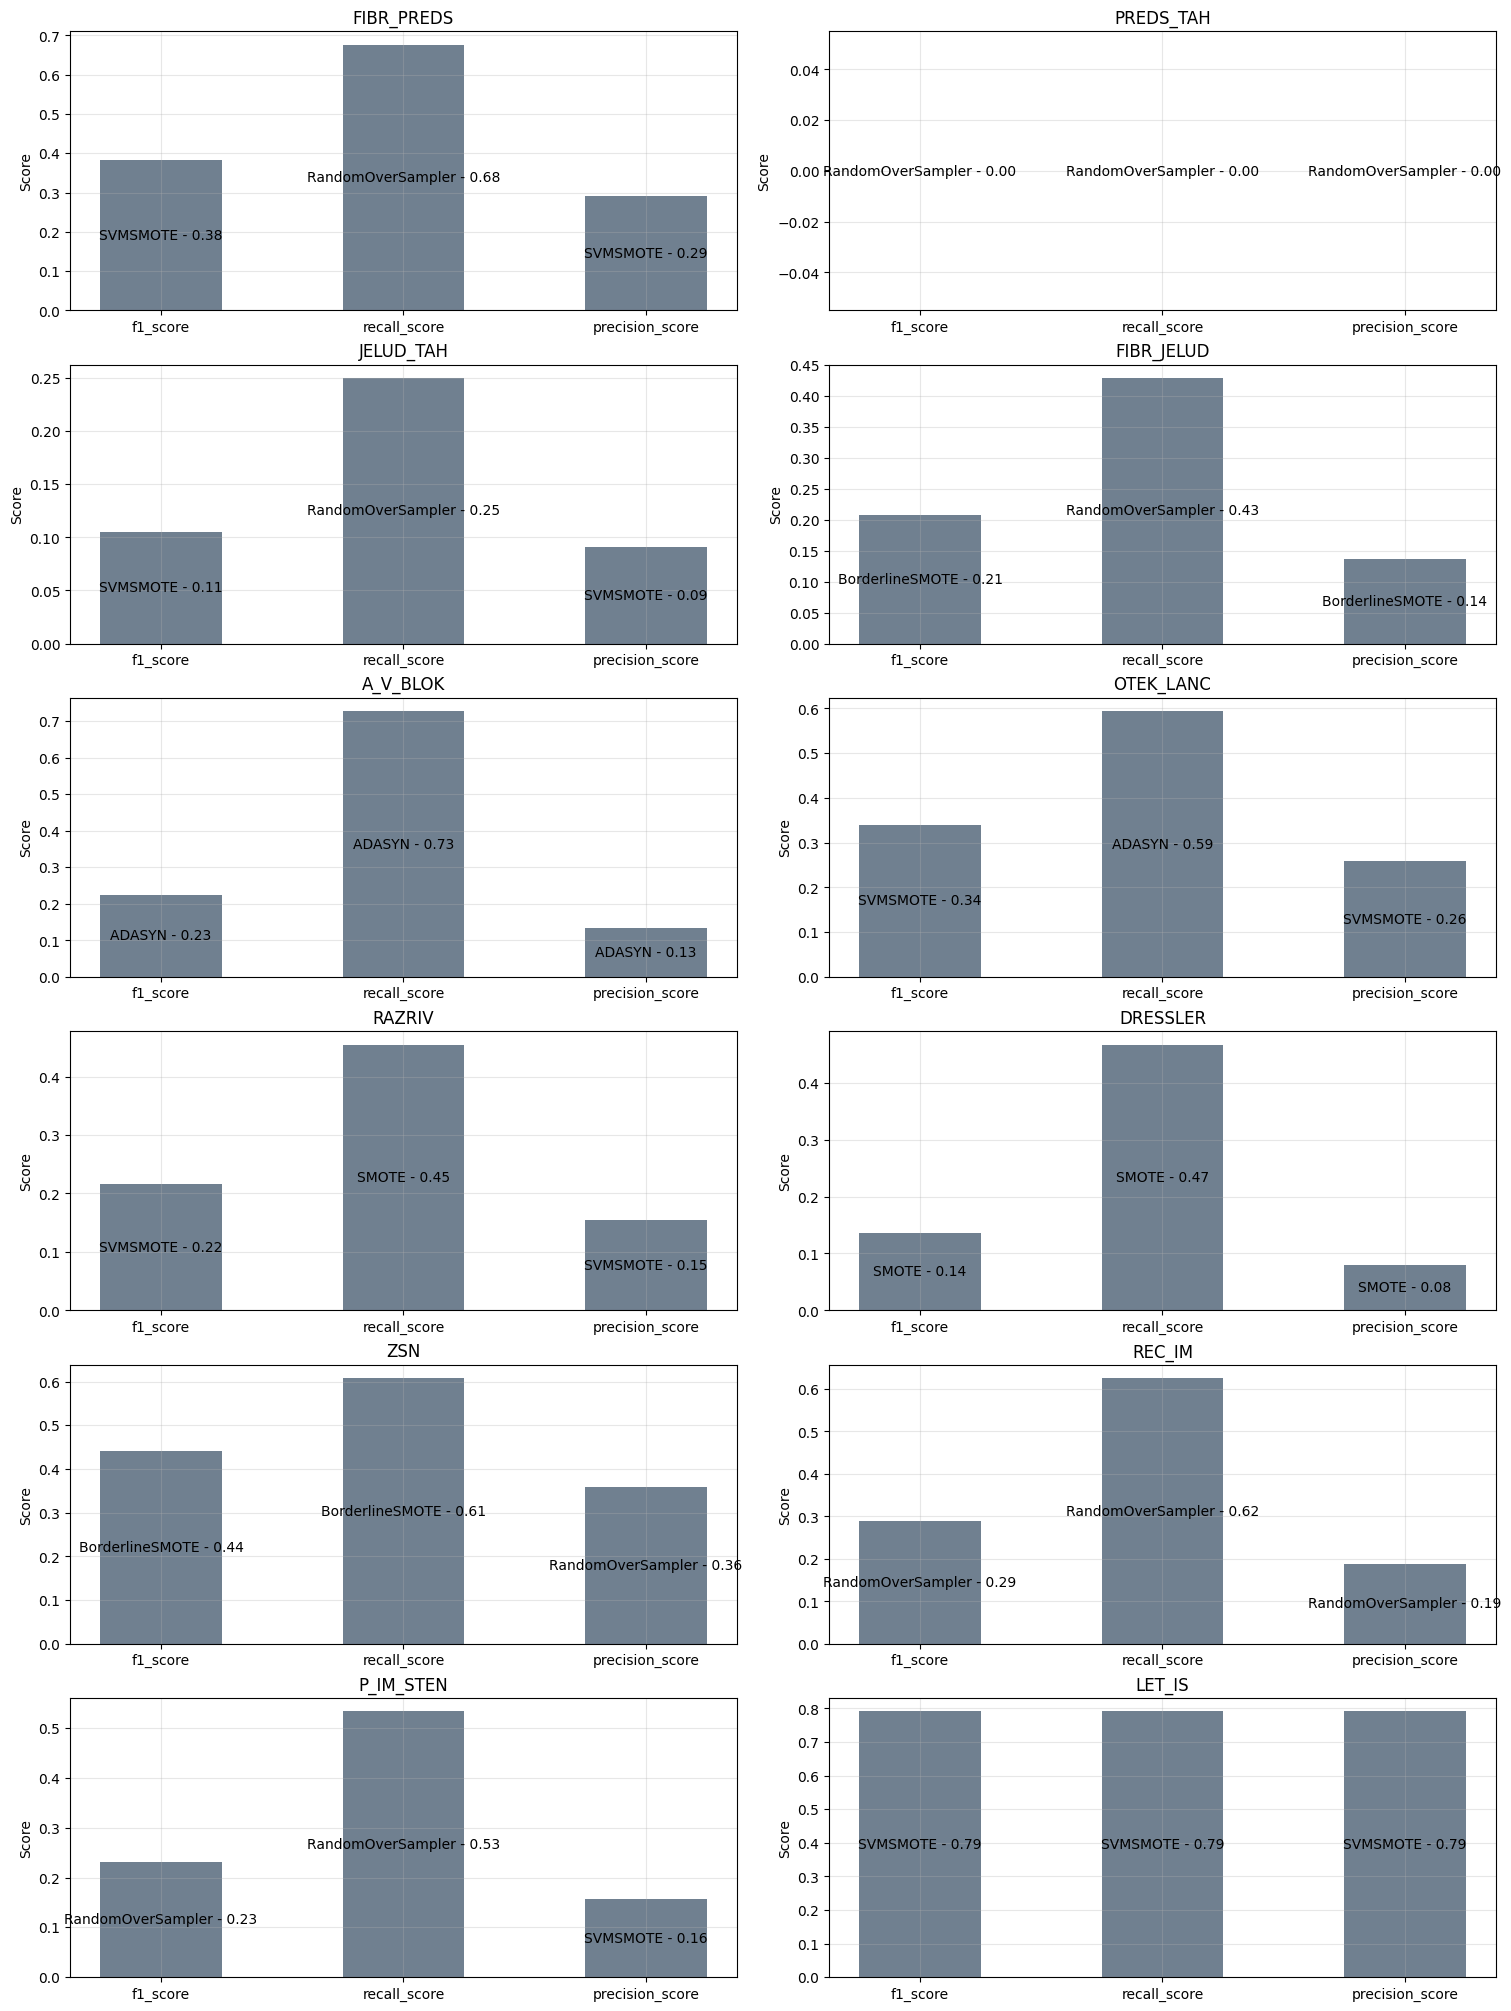

In [33]:
fig, axes = plt.subplots(
    nrows=int(len(target_columns) / ncols),
    ncols=ncols,
    constrained_layout=True,
    figsize=(15, 20),
)
axes = axes.reshape(-1)
for idx, target in enumerate(target_columns):
    best_metrics_target = best_metrics_oversampling_df[
        best_metrics_oversampling_df[3] == target
    ]
    axes[idx].bar(
        x=best_metrics_target[4],
        height=best_metrics_target[1],
        width=0.5,
        color="slategray",
    )

    rects = axes[idx].patches
    labels = [
        f"{oversampler} - {score:.2f}"
        for score, oversampler in zip(best_metrics_target[1], best_metrics_target[2])
    ]

    for rect, label in zip(rects, labels):
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        axes[idx].annotate(
            label,
            (x_value, y_value),
            xytext=(x_value, y_value / 2),
            ha="center",
            va="center",
        )
    axes[idx].set_title(target)
    axes[idx].set_ylabel("Score")
    axes[idx].grid(alpha=0.3)

Well, for some of the targets Random OverSampling seems like a good idea. SMOTE also achieved quite outstanding results compared to the original scores.

For now, let's incorporate the algorithms for respective targets and try to find the hyperparameters of the model.

In [34]:
best_oversamplers = {}
for target in target_columns:
    metrics_for_target = best_metrics_oversampling_df[
        best_metrics_oversampling_df[3] == target
    ]
    sampler = metrics_for_target[metrics_for_target[4] == "recall_score"][2].iloc[0]
    print(f"Target = {target}, Best OverSampler = {sampler}")
    if sampler == SMOTENC:
        init_sampler = globals()[sampler](
            random_state=SEED, categorical_features=categorical_features_indices
        )
    else:
        init_sampler = globals()[sampler](random_state=SEED)
    best_oversamplers[target] = init_sampler

Target = FIBR_PREDS, Best OverSampler = RandomOverSampler
Target = PREDS_TAH, Best OverSampler = RandomOverSampler
Target = JELUD_TAH, Best OverSampler = RandomOverSampler
Target = FIBR_JELUD, Best OverSampler = RandomOverSampler
Target = A_V_BLOK, Best OverSampler = ADASYN
Target = OTEK_LANC, Best OverSampler = ADASYN
Target = RAZRIV, Best OverSampler = SMOTE
Target = DRESSLER, Best OverSampler = SMOTE
Target = ZSN, Best OverSampler = BorderlineSMOTE
Target = REC_IM, Best OverSampler = RandomOverSampler
Target = P_IM_STEN, Best OverSampler = RandomOverSampler
Target = LET_IS, Best OverSampler = SVMSMOTE


##### Tuning hyper-parameters of Logistic Regression

In [35]:
def objective(trial, X, y, oversampler, average):
    C = trial.suggest_float("C", 1e-10, 1e10, log=True)
    class_weight = trial.suggest_categorical("class_weight", [None, "balanced"])
    solver = trial.suggest_categorical("solver", ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"])
    log_reg = LogisticRegression(C=C, class_weight=class_weight, solver=solver, random_state=SEED, max_iter=MAX_ITER, n_jobs=-1)
    X_train, X_eval, y_train, y_eval = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=SEED
    )
    X_train, y_train = oversampler.fit_resample(X_train, y_train)
    log_reg.fit(X_train, y_train)
    return recall_score(y_eval, log_reg.predict(X_eval), average=average, zero_division=0)

In [36]:
best_params = {}
for target in target_columns:
    study = optuna.create_study(direction="maximize", study_name=target)
    if target != "LET_IS":
        average = "binary"
    else:
        average = "micro"
    y = infarction_df[target]
    study.optimize(lambda trial: objective(trial, X, y, best_oversamplers[target], average), n_trials=100)
    best_params[target] = study.best_params

[I 2023-06-28 16:48:56,771] A new study created in memory with name: FIBR_PREDS
/home/proven_warrior/hse/first_year_project/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2023-06-28 16:49:01,270] Trial 0 finished with value: 0.5588235294117647 and parameters: {'C': 5819655924.351394, 'class_weight': None, 'solver': 'saga'}. Best is trial 0 with value: 0.5588235294117647.
[I 2023-06-28 16:49:01,452] Trial 1 finished with value: 0.7647058823529411 and parameters: {'C': 0.0012242319238464684, 'class_weight': 'balanced', 'solver': 'saga'}. Best is trial 1 with value: 0.7647058823529411.
/home/proven_warrior/hse/first_year_project/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2023-06-28 16:49:05,940] Trial 2 finished with value: 0.55882352941

[I 2023-06-28 16:49:19,759] Trial 32 finished with value: 0.8235294117647058 and parameters: {'C': 9.837399557000698e-05, 'class_weight': 'balanced', 'solver': 'saga'}. Best is trial 15 with value: 0.8235294117647058.
[I 2023-06-28 16:49:19,949] Trial 33 finished with value: 0.7352941176470589 and parameters: {'C': 0.008762814953094517, 'class_weight': 'balanced', 'solver': 'saga'}. Best is trial 15 with value: 0.8235294117647058.
[I 2023-06-28 16:49:20,132] Trial 34 finished with value: 0.7941176470588235 and parameters: {'C': 0.0006145068708966471, 'class_weight': 'balanced', 'solver': 'saga'}. Best is trial 15 with value: 0.8235294117647058.
[I 2023-06-28 16:49:20,287] Trial 35 finished with value: 0.7941176470588235 and parameters: {'C': 1.0310948484402873e-05, 'class_weight': None, 'solver': 'saga'}. Best is trial 15 with value: 0.8235294117647058.
[I 2023-06-28 16:49:20,487] Trial 36 finished with value: 0.7941176470588235 and parameters: {'C': 0.00022905394231340166, 'class_weig

[I 2023-06-28 16:49:31,526] Trial 68 finished with value: 0.7941176470588235 and parameters: {'C': 0.0007487680990107293, 'class_weight': None, 'solver': 'newton-cholesky'}. Best is trial 15 with value: 0.8235294117647058.
[I 2023-06-28 16:49:31,723] Trial 69 finished with value: 0.8235294117647058 and parameters: {'C': 8.329037362298322e-05, 'class_weight': 'balanced', 'solver': 'saga'}. Best is trial 15 with value: 0.8235294117647058.
[I 2023-06-28 16:49:31,907] Trial 70 finished with value: 0.7941176470588235 and parameters: {'C': 1.6442830510700308e-05, 'class_weight': 'balanced', 'solver': 'sag'}. Best is trial 15 with value: 0.8235294117647058.
[I 2023-06-28 16:49:32,093] Trial 71 finished with value: 0.8235294117647058 and parameters: {'C': 7.742710043039165e-05, 'class_weight': 'balanced', 'solver': 'saga'}. Best is trial 15 with value: 0.8235294117647058.
[I 2023-06-28 16:49:32,319] Trial 72 finished with value: 0.8235294117647058 and parameters: {'C': 0.00019790773706819336, 

[I 2023-06-28 16:49:44,420] Trial 2 finished with value: 0.0 and parameters: {'C': 8856.429173065104, 'class_weight': None, 'solver': 'newton-cholesky'}. Best is trial 0 with value: 1.0.
[I 2023-06-28 16:49:46,165] Trial 3 finished with value: 0.0 and parameters: {'C': 450287667.0466815, 'class_weight': 'balanced', 'solver': 'lbfgs'}. Best is trial 0 with value: 1.0.
/home/proven_warrior/hse/first_year_project/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2023-06-28 16:49:51,560] Trial 4 finished with value: 0.0 and parameters: {'C': 26979438.03960613, 'class_weight': None, 'solver': 'saga'}. Best is trial 0 with value: 1.0.
[I 2023-06-28 16:49:52,467] Trial 5 finished with value: 0.0 and parameters: {'C': 12227.922330929223, 'class_weight': 'balanced', 'solver': 'newton-cg'}. Best is trial 0 with value: 1.0.
/home/proven_warrior/hse/first_year_project/.venv/li

/home/proven_warrior/hse/first_year_project/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(
[I 2023-06-28 16:50:04,013] Trial 30 finished with value: 1.0 and parameters: {'C': 8.464035614715626e-06, 'class_weight': 'balanced', 'solver': 'liblinear'}. Best is trial 0 with value: 1.0.
/home/proven_warrior/hse/first_year_project/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(
[I 2023-06-28 16:50:04,130] Trial 31 finished with value: 1.0 and parameters: {'C': 2.914591335475341e-09, 'class_weight': 'balanced', 'solver': 'liblinear'}. Best is trial 0 with value: 1.0.
/home/proven_warrior/hse/first_year_project/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning

[I 2023-06-28 16:50:16,033] Trial 57 finished with value: 1.0 and parameters: {'C': 1.7346183706317032e-06, 'class_weight': 'balanced', 'solver': 'lbfgs'}. Best is trial 0 with value: 1.0.
[I 2023-06-28 16:50:16,208] Trial 58 finished with value: 0.0 and parameters: {'C': 1.2783683445749218e-10, 'class_weight': 'balanced', 'solver': 'saga'}. Best is trial 0 with value: 1.0.
/home/proven_warrior/hse/first_year_project/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(
[I 2023-06-28 16:50:16,348] Trial 59 finished with value: 1.0 and parameters: {'C': 2.1480293051700656e-09, 'class_weight': 'balanced', 'solver': 'liblinear'}. Best is trial 0 with value: 1.0.
/home/proven_warrior/hse/first_year_project/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is 

/home/proven_warrior/hse/first_year_project/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(
[I 2023-06-28 16:50:22,577] Trial 82 finished with value: 1.0 and parameters: {'C': 3.615416692676143e-06, 'class_weight': 'balanced', 'solver': 'liblinear'}. Best is trial 0 with value: 1.0.
/home/proven_warrior/hse/first_year_project/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(
[I 2023-06-28 16:50:22,686] Trial 83 finished with value: 1.0 and parameters: {'C': 2.3302527830700464e-09, 'class_weight': 'balanced', 'solver': 'liblinear'}. Best is trial 0 with value: 1.0.
[I 2023-06-28 16:50:22,919] Trial 84 finished with value: 0.0 and parameters: {'C': 8.279958044084408e-08, 'class_weight': 'balan

[I 2023-06-28 16:50:38,447] Trial 14 finished with value: 0.0 and parameters: {'C': 4.984536404265827e-08, 'class_weight': None, 'solver': 'saga'}. Best is trial 3 with value: 0.875.
/home/proven_warrior/hse/first_year_project/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(
[I 2023-06-28 16:50:38,556] Trial 15 finished with value: 0.625 and parameters: {'C': 0.006473072167253488, 'class_weight': None, 'solver': 'liblinear'}. Best is trial 3 with value: 0.875.
[I 2023-06-28 16:50:38,999] Trial 16 finished with value: 0.375 and parameters: {'C': 85.18168278397717, 'class_weight': None, 'solver': 'newton-cg'}. Best is trial 3 with value: 0.875.
[I 2023-06-28 16:50:40,125] Trial 17 finished with value: 0.875 and parameters: {'C': 4.3493563038902405e-08, 'class_weight': 'balanced', 'solver': 'lbfgs'}. Best is trial 3 with value: 0.875.
[I 202

[I 2023-06-28 16:50:55,992] Trial 52 finished with value: 0.875 and parameters: {'C': 1.0427913016110604e-10, 'class_weight': None, 'solver': 'newton-cg'}. Best is trial 3 with value: 0.875.
[I 2023-06-28 16:50:56,219] Trial 53 finished with value: 0.625 and parameters: {'C': 8.84630068556445e-09, 'class_weight': None, 'solver': 'newton-cg'}. Best is trial 3 with value: 0.875.
[I 2023-06-28 16:50:56,435] Trial 54 finished with value: 0.625 and parameters: {'C': 5.673329237034599e-10, 'class_weight': None, 'solver': 'newton-cg'}. Best is trial 3 with value: 0.875.
[I 2023-06-28 16:50:56,671] Trial 55 finished with value: 0.625 and parameters: {'C': 1.5176587516924352e-07, 'class_weight': None, 'solver': 'newton-cg'}. Best is trial 3 with value: 0.875.
[I 2023-06-28 16:50:57,801] Trial 56 finished with value: 0.875 and parameters: {'C': 6.799580691671924e-09, 'class_weight': None, 'solver': 'lbfgs'}. Best is trial 3 with value: 0.875.
[I 2023-06-28 16:50:58,024] Trial 57 finished with va

[I 2023-06-28 16:51:12,954] Trial 89 finished with value: 0.625 and parameters: {'C': 4.675790850472201e-06, 'class_weight': 'balanced', 'solver': 'lbfgs'}. Best is trial 3 with value: 0.875.
[I 2023-06-28 16:51:13,200] Trial 90 finished with value: 0.625 and parameters: {'C': 3.112010106751052e-10, 'class_weight': None, 'solver': 'newton-cg'}. Best is trial 3 with value: 0.875.
[I 2023-06-28 16:51:13,432] Trial 91 finished with value: 0.625 and parameters: {'C': 2.716481678789214e-10, 'class_weight': None, 'solver': 'newton-cg'}. Best is trial 3 with value: 0.875.
[I 2023-06-28 16:51:13,664] Trial 92 finished with value: 0.625 and parameters: {'C': 4.565983762803409e-09, 'class_weight': None, 'solver': 'newton-cg'}. Best is trial 3 with value: 0.875.
[I 2023-06-28 16:51:13,901] Trial 93 finished with value: 0.625 and parameters: {'C': 1.243992977240552e-09, 'class_weight': None, 'solver': 'newton-cg'}. Best is trial 3 with value: 0.875.
[I 2023-06-28 16:51:14,023] Trial 94 finished wi

[I 2023-06-28 16:51:29,355] Trial 20 finished with value: 0.6428571428571429 and parameters: {'C': 3.6357445458559206e-09, 'class_weight': 'balanced', 'solver': 'newton-cg'}. Best is trial 3 with value: 0.6428571428571429.
/home/proven_warrior/hse/first_year_project/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(
[I 2023-06-28 16:51:29,468] Trial 21 finished with value: 0.6428571428571429 and parameters: {'C': 1.0884092249939568e-09, 'class_weight': None, 'solver': 'liblinear'}. Best is trial 3 with value: 0.6428571428571429.
/home/proven_warrior/hse/first_year_project/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(
[I 2023-06-28 16:51:29,606] Trial 22 finished with value: 0.64285714285714

[I 2023-06-28 16:51:41,405] Trial 47 finished with value: 0.6428571428571429 and parameters: {'C': 1.2672684589179946e-10, 'class_weight': 'balanced', 'solver': 'lbfgs'}. Best is trial 3 with value: 0.6428571428571429.
[I 2023-06-28 16:51:41,643] Trial 48 finished with value: 0.42857142857142855 and parameters: {'C': 2.7008531979095198e-05, 'class_weight': 'balanced', 'solver': 'newton-cg'}. Best is trial 3 with value: 0.6428571428571429.
[I 2023-06-28 16:51:41,841] Trial 49 finished with value: 0.0 and parameters: {'C': 7.536054414021195e-08, 'class_weight': 'balanced', 'solver': 'sag'}. Best is trial 3 with value: 0.6428571428571429.
/home/proven_warrior/hse/first_year_project/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(
[I 2023-06-28 16:51:41,941] Trial 50 finished with value: 0.6428571428571429 and parameters: {'C': 4.104770711401

[I 2023-06-28 16:51:48,419] Trial 71 finished with value: 0.6428571428571429 and parameters: {'C': 6.020462296841002e-08, 'class_weight': None, 'solver': 'lbfgs'}. Best is trial 3 with value: 0.6428571428571429.
[I 2023-06-28 16:51:49,520] Trial 72 finished with value: 0.6428571428571429 and parameters: {'C': 2.8976506969284083e-10, 'class_weight': None, 'solver': 'lbfgs'}. Best is trial 3 with value: 0.6428571428571429.
[I 2023-06-28 16:51:50,661] Trial 73 finished with value: 0.6428571428571429 and parameters: {'C': 2.076688936334765e-09, 'class_weight': None, 'solver': 'lbfgs'}. Best is trial 3 with value: 0.6428571428571429.
[I 2023-06-28 16:51:51,782] Trial 74 finished with value: 0.6428571428571429 and parameters: {'C': 6.729184476348872e-07, 'class_weight': None, 'solver': 'lbfgs'}. Best is trial 3 with value: 0.6428571428571429.
[I 2023-06-28 16:51:52,924] Trial 75 finished with value: 0.6428571428571429 and parameters: {'C': 1.1986371134367776e-08, 'class_weight': None, 'solve

[I 2023-06-28 16:51:59,592] Trial 97 finished with value: 0.42857142857142855 and parameters: {'C': 4.756860765643729e-08, 'class_weight': 'balanced', 'solver': 'newton-cg'}. Best is trial 3 with value: 0.6428571428571429.
[I 2023-06-28 16:52:00,717] Trial 98 finished with value: 0.6428571428571429 and parameters: {'C': 2.937478104671972e-09, 'class_weight': None, 'solver': 'lbfgs'}. Best is trial 3 with value: 0.6428571428571429.
/home/proven_warrior/hse/first_year_project/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(
[I 2023-06-28 16:52:00,863] Trial 99 finished with value: 0.6428571428571429 and parameters: {'C': 9.305414879034243e-10, 'class_weight': 'balanced', 'solver': 'liblinear'}. Best is trial 3 with value: 0.6428571428571429.
[I 2023-06-28 16:52:00,876] A new study created in memory with name: A_V_BLOK
[I 2023-06-28 16:52:01

[I 2023-06-28 16:52:20,274] Trial 32 finished with value: 1.0 and parameters: {'C': 6.853201824087666e-08, 'class_weight': 'balanced', 'solver': 'sag'}. Best is trial 4 with value: 1.0.
[I 2023-06-28 16:52:20,473] Trial 33 finished with value: 1.0 and parameters: {'C': 8.100813971198437e-10, 'class_weight': 'balanced', 'solver': 'sag'}. Best is trial 4 with value: 1.0.
[I 2023-06-28 16:52:20,743] Trial 34 finished with value: 0.5454545454545454 and parameters: {'C': 1.7585086051820505e-09, 'class_weight': 'balanced', 'solver': 'newton-cholesky'}. Best is trial 4 with value: 1.0.
[I 2023-06-28 16:52:20,949] Trial 35 finished with value: 0.36363636363636365 and parameters: {'C': 1.9977513456724093e-07, 'class_weight': 'balanced', 'solver': 'sag'}. Best is trial 4 with value: 1.0.
[I 2023-06-28 16:52:21,177] Trial 36 finished with value: 1.0 and parameters: {'C': 1.6323837541126944e-08, 'class_weight': 'balanced', 'solver': 'sag'}. Best is trial 4 with value: 1.0.
[I 2023-06-28 16:52:21,4

[I 2023-06-28 16:52:32,512] Trial 71 finished with value: 1.0 and parameters: {'C': 4.6363837032017846e-09, 'class_weight': 'balanced', 'solver': 'sag'}. Best is trial 4 with value: 1.0.
[I 2023-06-28 16:52:32,718] Trial 72 finished with value: 1.0 and parameters: {'C': 3.528597781238893e-10, 'class_weight': 'balanced', 'solver': 'sag'}. Best is trial 4 with value: 1.0.
[I 2023-06-28 16:52:33,001] Trial 73 finished with value: 1.0 and parameters: {'C': 2.3990321598680645e-08, 'class_weight': 'balanced', 'solver': 'sag'}. Best is trial 4 with value: 1.0.
[I 2023-06-28 16:52:33,268] Trial 74 finished with value: 1.0 and parameters: {'C': 7.762540354430597e-08, 'class_weight': 'balanced', 'solver': 'sag'}. Best is trial 4 with value: 1.0.
[I 2023-06-28 16:52:33,546] Trial 75 finished with value: 0.5454545454545454 and parameters: {'C': 1.0307923246984222e-09, 'class_weight': 'balanced', 'solver': 'newton-cg'}. Best is trial 4 with value: 1.0.
[I 2023-06-28 16:52:33,771] Trial 76 finished 

[I 2023-06-28 16:52:50,876] Trial 7 finished with value: 0.625 and parameters: {'C': 3.2644547780371084e-06, 'class_weight': 'balanced', 'solver': 'sag'}. Best is trial 0 with value: 0.78125.
[I 2023-06-28 16:52:52,658] Trial 8 finished with value: 0.53125 and parameters: {'C': 10722706.038877985, 'class_weight': None, 'solver': 'newton-cg'}. Best is trial 0 with value: 0.78125.
/home/proven_warrior/hse/first_year_project/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[I 2023-06-28 16:52:54,468] Trial 9 finished with value: 0.53125 and

[I 2023-06-28 16:53:04,884] Trial 45 finished with value: 0.625 and parameters: {'C': 0.0003113545175890298, 'class_weight': None, 'solver': 'newton-cg'}. Best is trial 28 with value: 1.0.
[I 2023-06-28 16:53:05,168] Trial 46 finished with value: 0.625 and parameters: {'C': 1.031509935397215e-07, 'class_weight': 'balanced', 'solver': 'newton-cg'}. Best is trial 28 with value: 1.0.
[I 2023-06-28 16:53:06,337] Trial 47 finished with value: 1.0 and parameters: {'C': 1.3922705306820589e-09, 'class_weight': None, 'solver': 'lbfgs'}. Best is trial 28 with value: 1.0.
[I 2023-06-28 16:53:06,561] Trial 48 finished with value: 1.0 and parameters: {'C': 1.9563316163627605e-05, 'class_weight': None, 'solver': 'sag'}. Best is trial 28 with value: 1.0.
/home/proven_warrior/hse/first_year_project/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(
[I 2023

[I 2023-06-28 16:53:18,705] Trial 85 finished with value: 1.0 and parameters: {'C': 2.750379206995614e-06, 'class_weight': None, 'solver': 'newton-cg'}. Best is trial 28 with value: 1.0.
[I 2023-06-28 16:53:18,982] Trial 86 finished with value: 1.0 and parameters: {'C': 8.84411601563744e-10, 'class_weight': None, 'solver': 'newton-cg'}. Best is trial 28 with value: 1.0.
[I 2023-06-28 16:53:19,260] Trial 87 finished with value: 1.0 and parameters: {'C': 8.58374890204317e-07, 'class_weight': None, 'solver': 'newton-cg'}. Best is trial 28 with value: 1.0.
[I 2023-06-28 16:53:19,528] Trial 88 finished with value: 1.0 and parameters: {'C': 2.0910136783864305e-07, 'class_weight': None, 'solver': 'newton-cholesky'}. Best is trial 28 with value: 1.0.
[I 2023-06-28 16:53:20,079] Trial 89 finished with value: 1.0 and parameters: {'C': 6.937670371997173e-08, 'class_weight': None, 'solver': 'saga'}. Best is trial 28 with value: 1.0.
[I 2023-06-28 16:53:20,360] Trial 90 finished with value: 1.0 and

[I 2023-06-28 16:53:44,667] Trial 20 finished with value: 0.7272727272727273 and parameters: {'C': 2.3542152772820388e-06, 'class_weight': None, 'solver': 'sag'}. Best is trial 5 with value: 1.0.
[I 2023-06-28 16:53:44,856] Trial 21 finished with value: 1.0 and parameters: {'C': 1.8372095903332782e-09, 'class_weight': None, 'solver': 'sag'}. Best is trial 5 with value: 1.0.
[I 2023-06-28 16:53:45,080] Trial 22 finished with value: 1.0 and parameters: {'C': 7.039419481658379e-09, 'class_weight': None, 'solver': 'sag'}. Best is trial 5 with value: 1.0.
[I 2023-06-28 16:53:45,270] Trial 23 finished with value: 1.0 and parameters: {'C': 5.458960632763102e-09, 'class_weight': None, 'solver': 'sag'}. Best is trial 5 with value: 1.0.
[I 2023-06-28 16:53:45,469] Trial 24 finished with value: 1.0 and parameters: {'C': 1.0026813834413725e-10, 'class_weight': None, 'solver': 'sag'}. Best is trial 5 with value: 1.0.
[I 2023-06-28 16:53:45,675] Trial 25 finished with value: 0.7272727272727273 and p

[I 2023-06-28 16:53:54,704] Trial 60 finished with value: 0.7272727272727273 and parameters: {'C': 3.702571314239265e-08, 'class_weight': None, 'solver': 'newton-cholesky'}. Best is trial 5 with value: 1.0.
[I 2023-06-28 16:53:54,931] Trial 61 finished with value: 1.0 and parameters: {'C': 5.227571328102985e-09, 'class_weight': None, 'solver': 'sag'}. Best is trial 5 with value: 1.0.
[I 2023-06-28 16:53:55,126] Trial 62 finished with value: 1.0 and parameters: {'C': 6.171772580886556e-10, 'class_weight': None, 'solver': 'sag'}. Best is trial 5 with value: 1.0.
[I 2023-06-28 16:53:55,340] Trial 63 finished with value: 1.0 and parameters: {'C': 6.772435338838615e-09, 'class_weight': None, 'solver': 'sag'}. Best is trial 5 with value: 1.0.
[I 2023-06-28 16:53:55,570] Trial 64 finished with value: 1.0 and parameters: {'C': 1.0021206231099965e-10, 'class_weight': None, 'solver': 'sag'}. Best is trial 5 with value: 1.0.
[I 2023-06-28 16:53:56,730] Trial 65 finished with value: 0.909090909090

/home/proven_warrior/hse/first_year_project/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(
[I 2023-06-28 16:54:06,463] Trial 1 finished with value: 0.3333333333333333 and parameters: {'C': 3576073718.836868, 'class_weight': 'balanced', 'solver': 'liblinear'}. Best is trial 0 with value: 0.6666666666666666.
/home/proven_warrior/hse/first_year_project/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2023-06-28 16:54:10,373] Trial 2 finished with value: 0.3333333333333333 and parameters: {'C': 3610.113909006893, 'class_weight': None, 'solver': 'sag'}. Best is trial 0 with value: 0.6666666666666666.
[I 2023-06-28 16:54:10,656] Trial 3 finished with value: 0.4666666666666667 and parameters: {'C': 0.025125270568460298, '

[I 2023-06-28 16:54:28,742] Trial 32 finished with value: 0.6666666666666666 and parameters: {'C': 5.1595232183149485e-06, 'class_weight': 'balanced', 'solver': 'saga'}. Best is trial 0 with value: 0.6666666666666666.
[I 2023-06-28 16:54:29,027] Trial 33 finished with value: 0.0 and parameters: {'C': 1.5143183800159554e-07, 'class_weight': 'balanced', 'solver': 'saga'}. Best is trial 0 with value: 0.6666666666666666.
[I 2023-06-28 16:54:29,238] Trial 34 finished with value: 0.6666666666666666 and parameters: {'C': 2.1392525637251137e-05, 'class_weight': 'balanced', 'solver': 'saga'}. Best is trial 0 with value: 0.6666666666666666.
[I 2023-06-28 16:54:29,810] Trial 35 finished with value: 0.4666666666666667 and parameters: {'C': 0.7511331570730893, 'class_weight': None, 'solver': 'sag'}. Best is trial 0 with value: 0.6666666666666666.
[I 2023-06-28 16:54:30,072] Trial 36 finished with value: 0.6 and parameters: {'C': 0.0024312588415015195, 'class_weight': 'balanced', 'solver': 'newton-c

[I 2023-06-28 16:54:47,521] Trial 67 finished with value: 0.6666666666666666 and parameters: {'C': 6.453386529781158e-06, 'class_weight': None, 'solver': 'saga'}. Best is trial 0 with value: 0.6666666666666666.
[I 2023-06-28 16:54:47,760] Trial 68 finished with value: 0.6666666666666666 and parameters: {'C': 6.803230052542724e-07, 'class_weight': 'balanced', 'solver': 'newton-cholesky'}. Best is trial 0 with value: 0.6666666666666666.
[I 2023-06-28 16:54:47,972] Trial 69 finished with value: 0.6666666666666666 and parameters: {'C': 4.496289025234157e-05, 'class_weight': 'balanced', 'solver': 'sag'}. Best is trial 0 with value: 0.6666666666666666.
[I 2023-06-28 16:54:48,263] Trial 70 finished with value: 0.13333333333333333 and parameters: {'C': 2.3815578203767132e-07, 'class_weight': None, 'solver': 'saga'}. Best is trial 0 with value: 0.6666666666666666.
[I 2023-06-28 16:54:48,523] Trial 71 finished with value: 0.6666666666666666 and parameters: {'C': 2.6132916558860574e-06, 'class_we

[I 2023-06-28 16:54:59,954] Trial 1 finished with value: 0.6962025316455697 and parameters: {'C': 1.4746161945708216e-05, 'class_weight': 'balanced', 'solver': 'newton-cg'}. Best is trial 1 with value: 0.6962025316455697.
[I 2023-06-28 16:55:01,500] Trial 2 finished with value: 0.5822784810126582 and parameters: {'C': 1241.5456868827075, 'class_weight': 'balanced', 'solver': 'lbfgs'}. Best is trial 1 with value: 0.6962025316455697.
[I 2023-06-28 16:55:02,682] Trial 3 finished with value: 0.7848101265822784 and parameters: {'C': 5.533058830486645e-06, 'class_weight': 'balanced', 'solver': 'lbfgs'}. Best is trial 3 with value: 0.7848101265822784.
[I 2023-06-28 16:55:03,482] Trial 4 finished with value: 0.5822784810126582 and parameters: {'C': 99934.17782469346, 'class_weight': None, 'solver': 'newton-cg'}. Best is trial 3 with value: 0.7848101265822784.
[I 2023-06-28 16:55:05,120] Trial 5 finished with value: 0.5822784810126582 and parameters: {'C': 104930.6874714841, 'class_weight': 'ba

[I 2023-06-28 16:55:29,185] Trial 32 finished with value: 0.6835443037974683 and parameters: {'C': 1.7741802972316363e-05, 'class_weight': 'balanced', 'solver': 'lbfgs'}. Best is trial 3 with value: 0.7848101265822784.
[I 2023-06-28 16:55:30,405] Trial 33 finished with value: 0.7848101265822784 and parameters: {'C': 3.0337029932689746e-09, 'class_weight': 'balanced', 'solver': 'lbfgs'}. Best is trial 3 with value: 0.7848101265822784.
[I 2023-06-28 16:55:31,650] Trial 34 finished with value: 0.7848101265822784 and parameters: {'C': 1.623553633418574e-07, 'class_weight': 'balanced', 'solver': 'lbfgs'}. Best is trial 3 with value: 0.7848101265822784.
[I 2023-06-28 16:55:31,912] Trial 35 finished with value: 0.7088607594936709 and parameters: {'C': 1.4366257959714481e-05, 'class_weight': 'balanced', 'solver': 'sag'}. Best is trial 3 with value: 0.7848101265822784.
[I 2023-06-28 16:55:33,124] Trial 36 finished with value: 0.7848101265822784 and parameters: {'C': 1.6639472081802651e-06, 'cla

[I 2023-06-28 16:56:01,574] Trial 68 finished with value: 0.6075949367088608 and parameters: {'C': 5.911452841409455e-07, 'class_weight': 'balanced', 'solver': 'sag'}. Best is trial 3 with value: 0.7848101265822784.
[I 2023-06-28 16:56:02,758] Trial 69 finished with value: 0.7848101265822784 and parameters: {'C': 2.335425869417994e-09, 'class_weight': 'balanced', 'solver': 'lbfgs'}. Best is trial 3 with value: 0.7848101265822784.
[I 2023-06-28 16:56:02,987] Trial 70 finished with value: 0.0 and parameters: {'C': 7.58710068414071e-09, 'class_weight': 'balanced', 'solver': 'saga'}. Best is trial 3 with value: 0.7848101265822784.
[I 2023-06-28 16:56:04,170] Trial 71 finished with value: 0.7848101265822784 and parameters: {'C': 4.209341185081235e-06, 'class_weight': 'balanced', 'solver': 'lbfgs'}. Best is trial 3 with value: 0.7848101265822784.
[I 2023-06-28 16:56:05,380] Trial 72 finished with value: 0.7848101265822784 and parameters: {'C': 1.9184528507279548e-07, 'class_weight': 'balance

[I 2023-06-28 16:56:31,101] Trial 3 finished with value: 0.5625 and parameters: {'C': 683067.8735749322, 'class_weight': 'balanced', 'solver': 'newton-cholesky'}. Best is trial 0 with value: 0.625.
/home/proven_warrior/hse/first_year_project/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2023-06-28 16:56:35,716] Trial 4 finished with value: 0.5625 and parameters: {'C': 894.9613303850417, 'class_weight': 'balanced', 'solver': 'saga'}. Best is trial 0 with value: 0.625.
[I 2023-06-28 16:56:36,029] Trial 5 finished with value: 0.625 and parameters: {'C': 2.032729534400875, 'class_weight': None, 'solver': 'newton-cg'}. Best is trial 0 with value: 0.625.
/home/proven_warrior/hse/first_year_project/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jo

[I 2023-06-28 16:56:54,419] Trial 42 finished with value: 1.0 and parameters: {'C': 4.639252847897219e-09, 'class_weight': None, 'solver': 'sag'}. Best is trial 24 with value: 1.0.
[I 2023-06-28 16:56:54,698] Trial 43 finished with value: 1.0 and parameters: {'C': 1.016786554010781e-07, 'class_weight': None, 'solver': 'sag'}. Best is trial 24 with value: 1.0.
[I 2023-06-28 16:56:54,913] Trial 44 finished with value: 0.65625 and parameters: {'C': 4.3903384302249565e-05, 'class_weight': None, 'solver': 'sag'}. Best is trial 24 with value: 1.0.
[I 2023-06-28 16:56:55,113] Trial 45 finished with value: 0.65625 and parameters: {'C': 1.0111092956392957e-06, 'class_weight': None, 'solver': 'sag'}. Best is trial 24 with value: 1.0.
[I 2023-06-28 16:56:55,343] Trial 46 finished with value: 0.65625 and parameters: {'C': 1.3619297802041442e-09, 'class_weight': None, 'solver': 'newton-cholesky'}. Best is trial 24 with value: 1.0.
[I 2023-06-28 16:56:55,752] Trial 47 finished with value: 1.0 and pa

[I 2023-06-28 16:57:04,131] Trial 82 finished with value: 1.0 and parameters: {'C': 8.062491145414128e-08, 'class_weight': None, 'solver': 'saga'}. Best is trial 24 with value: 1.0.
[I 2023-06-28 16:57:04,293] Trial 83 finished with value: 1.0 and parameters: {'C': 1.4083770749401935e-08, 'class_weight': None, 'solver': 'saga'}. Best is trial 24 with value: 1.0.
[I 2023-06-28 16:57:04,556] Trial 84 finished with value: 0.65625 and parameters: {'C': 5.804863146438107e-07, 'class_weight': None, 'solver': 'saga'}. Best is trial 24 with value: 1.0.
[I 2023-06-28 16:57:04,712] Trial 85 finished with value: 1.0 and parameters: {'C': 6.784111373089953e-10, 'class_weight': None, 'solver': 'saga'}. Best is trial 24 with value: 1.0.
[I 2023-06-28 16:57:04,872] Trial 86 finished with value: 1.0 and parameters: {'C': 2.1588904128646606e-09, 'class_weight': None, 'solver': 'sag'}. Best is trial 24 with value: 1.0.
[I 2023-06-28 16:57:05,042] Trial 87 finished with value: 1.0 and parameters: {'C': 2

[I 2023-06-28 16:57:25,259] Trial 16 finished with value: 0.5666666666666667 and parameters: {'C': 2.7946413700076835, 'class_weight': None, 'solver': 'newton-cholesky'}. Best is trial 12 with value: 0.6.
[I 2023-06-28 16:57:26,750] Trial 17 finished with value: 0.6 and parameters: {'C': 0.010397147172304656, 'class_weight': None, 'solver': 'lbfgs'}. Best is trial 12 with value: 0.6.
[I 2023-06-28 16:57:30,768] Trial 18 finished with value: 0.5666666666666667 and parameters: {'C': 9.817779109012687, 'class_weight': None, 'solver': 'saga'}. Best is trial 12 with value: 0.6.
/home/proven_warrior/hse/first_year_project/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(
[I 2023-06-28 16:57:30,879] Trial 19 finished with value: 0.5666666666666667 and parameters: {'C': 0.0028643368027471104, 'class_weight': None, 'solver': 'liblinear'}. Best is t

/home/proven_warrior/hse/first_year_project/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(
[I 2023-06-28 16:57:47,627] Trial 44 finished with value: 0.5 and parameters: {'C': 0.00024143231249506235, 'class_weight': None, 'solver': 'liblinear'}. Best is trial 12 with value: 0.6.
[I 2023-06-28 16:57:48,745] Trial 45 finished with value: 0.6 and parameters: {'C': 0.0051230459560560005, 'class_weight': None, 'solver': 'lbfgs'}. Best is trial 12 with value: 0.6.
[I 2023-06-28 16:57:48,973] Trial 46 finished with value: 0.5666666666666667 and parameters: {'C': 0.07290743774933235, 'class_weight': None, 'solver': 'newton-cholesky'}. Best is trial 12 with value: 0.6.
[I 2023-06-28 16:57:49,212] Trial 47 finished with value: 0.36666666666666664 and parameters: {'C': 3.7828410810865357e-07, 'class_weight': 'balanced', 'solver': 'saga'}. Best is t

[I 2023-06-28 16:58:04,769] Trial 73 finished with value: 0.5666666666666667 and parameters: {'C': 0.001555159184582711, 'class_weight': None, 'solver': 'lbfgs'}. Best is trial 12 with value: 0.6.
[I 2023-06-28 16:58:05,912] Trial 74 finished with value: 0.6 and parameters: {'C': 0.021066920871512764, 'class_weight': None, 'solver': 'lbfgs'}. Best is trial 12 with value: 0.6.
[I 2023-06-28 16:58:06,181] Trial 75 finished with value: 0.5666666666666667 and parameters: {'C': 0.07983824334068915, 'class_weight': None, 'solver': 'newton-cg'}. Best is trial 12 with value: 0.6.
[I 2023-06-28 16:58:07,323] Trial 76 finished with value: 0.5666666666666667 and parameters: {'C': 0.00014510691812906961, 'class_weight': None, 'solver': 'lbfgs'}. Best is trial 12 with value: 0.6.
[I 2023-06-28 16:58:07,556] Trial 77 finished with value: 0.5333333333333333 and parameters: {'C': 0.3729729060348257, 'class_weight': None, 'solver': 'newton-cholesky'}. Best is trial 12 with value: 0.6.
/home/proven_warr

/home/proven_warrior/hse/first_year_project/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2023-06-28 17:08:34,229] Trial 3 finished with value: 0.7558823529411764 and parameters: {'C': 41320.09374207425, 'class_weight': None, 'solver': 'saga'}. Best is trial 3 with value: 0.7558823529411764.
/home/proven_warrior/hse/first_year_project/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[I 2023-06-28 17:08:39,631] Tr

[I 2023-06-28 17:13:56,506] Trial 30 finished with value: 0.7911764705882353 and parameters: {'C': 6.242822670677054e-05, 'class_weight': None, 'solver': 'sag'}. Best is trial 29 with value: 0.7970588235294118.
[I 2023-06-28 17:13:58,033] Trial 31 finished with value: 0.7970588235294118 and parameters: {'C': 0.0001392485358426539, 'class_weight': None, 'solver': 'sag'}. Best is trial 29 with value: 0.7970588235294118.
[I 2023-06-28 17:13:59,563] Trial 32 finished with value: 0.7588235294117647 and parameters: {'C': 1.6694984076447862e-05, 'class_weight': None, 'solver': 'sag'}. Best is trial 29 with value: 0.7970588235294118.
[I 2023-06-28 17:14:01,091] Trial 33 finished with value: 0.8 and parameters: {'C': 0.00015017178647201774, 'class_weight': None, 'solver': 'sag'}. Best is trial 33 with value: 0.8.
[I 2023-06-28 17:14:02,639] Trial 34 finished with value: 0.75 and parameters: {'C': 1.1959494254385346e-05, 'class_weight': None, 'solver': 'sag'}. Best is trial 33 with value: 0.8.
[

[I 2023-06-28 17:15:05,753] Trial 67 finished with value: 0.7970588235294118 and parameters: {'C': 0.00011969931342800091, 'class_weight': None, 'solver': 'sag'}. Best is trial 56 with value: 0.8029411764705883.
[I 2023-06-28 17:15:07,275] Trial 68 finished with value: 0.8 and parameters: {'C': 0.00016286236934491384, 'class_weight': None, 'solver': 'sag'}. Best is trial 56 with value: 0.8029411764705883.
[I 2023-06-28 17:15:08,822] Trial 69 finished with value: 0.7970588235294118 and parameters: {'C': 0.0001820394633303, 'class_weight': None, 'solver': 'sag'}. Best is trial 56 with value: 0.8029411764705883.
[I 2023-06-28 17:15:12,872] Trial 70 finished with value: 0.7352941176470589 and parameters: {'C': 1.1896676637596892e-07, 'class_weight': None, 'solver': 'saga'}. Best is trial 56 with value: 0.8029411764705883.
[I 2023-06-28 17:15:14,398] Trial 71 finished with value: 0.8 and parameters: {'C': 0.00016315554537892215, 'class_weight': None, 'solver': 'sag'}. Best is trial 56 with 

In [38]:
pd.DataFrame(best_params)

,FIBR_PREDS,PREDS_TAH,JELUD_TAH,FIBR_JELUD,A_V_BLOK,OTEK_LANC,RAZRIV,DRESSLER,ZSN,REC_IM,P_IM_STEN,LET_IS
C,0.000111,0.0,0.0,0.0,0.0,0.000002,0.0,0.000033,0.000006,0.0,0.02005,0.000106
class_weight,balanced,balanced,balanced,balanced,balanced,None,None,None,balanced,None,None,None
solver,newton-cg,liblinear,newton-cg,lbfgs,sag,newton-cg,sag,newton-cg,lbfgs,sag,saga,sag


Now that we have found the best parameters for Logistic Regressions, let's try and compare our default models with better ones.

##### Final versions of Logistic Regressions for targets

In [45]:
default_scores = pd.DataFrame()

for target in target_columns:
    scores_for_target = train_log_reg(X, infarction_df[target], target, verbose_metrics=False)
    default_scores = pd.concat([default_scores, scores_for_target])

Target = FIBR_PREDS
FIBR_PREDS - f1_score:  0.1364
FIBR_PREDS - recall_score:  0.0882
FIBR_PREDS - precision_score:  0.3
Target = PREDS_TAH
PREDS_TAH - f1_score:  0.0
PREDS_TAH - recall_score:  0.0
PREDS_TAH - precision_score:  0.0
Target = JELUD_TAH
JELUD_TAH - f1_score:  0.0
JELUD_TAH - recall_score:  0.0
JELUD_TAH - precision_score:  0.0
Target = FIBR_JELUD
FIBR_JELUD - f1_score:  0.0
FIBR_JELUD - recall_score:  0.0
FIBR_JELUD - precision_score:  0.0
Target = A_V_BLOK
A_V_BLOK - f1_score:  0.1429
A_V_BLOK - recall_score:  0.0909
A_V_BLOK - precision_score:  0.3333
Target = OTEK_LANC
OTEK_LANC - f1_score:  0.1026
OTEK_LANC - recall_score:  0.0625
OTEK_LANC - precision_score:  0.2857
Target = RAZRIV
RAZRIV - f1_score:  0.0
RAZRIV - recall_score:  0.0
RAZRIV - precision_score:  0.0
Target = DRESSLER
DRESSLER - f1_score:  0.0
DRESSLER - recall_score:  0.0
DRESSLER - precision_score:  0.0
Target = ZSN
ZSN - f1_score:  0.1702
ZSN - recall_score:  0.1013
ZSN - precision_score:  0.5333
Targ

In [53]:
targets = default_scores["Metric name"].str.split(" - ").str[0]
metrics = default_scores["Metric name"].str.split(" - ").str[1]
default_scores["Metrics"] = metrics
default_scores["Targets"] = targets
default_scores["Type of model"] = "Default"
default_scores.head(5)

,Metric name,Score,Metrics,Targets,Type of model
0,FIBR_PREDS - f1_score,0.136364,f1_score,FIBR_PREDS,Default
1,FIBR_PREDS - recall_score,0.088235,recall_score,FIBR_PREDS,Default
2,FIBR_PREDS - precision_score,0.300000,precision_score,FIBR_PREDS,Default
0,PREDS_TAH - f1_score,0.000000,f1_score,PREDS_TAH,Default
1,PREDS_TAH - recall_score,0.000000,recall_score,PREDS_TAH,Default


In [55]:
best_oversamplers

{'FIBR_PREDS': RandomOverSampler(random_state=0),
 'PREDS_TAH': RandomOverSampler(random_state=0),
 'JELUD_TAH': RandomOverSampler(random_state=0),
 'FIBR_JELUD': RandomOverSampler(random_state=0),
 'A_V_BLOK': ADASYN(random_state=0),
 'OTEK_LANC': ADASYN(random_state=0),
 'RAZRIV': SMOTE(random_state=0),
 'DRESSLER': SMOTE(random_state=0),
 'ZSN': BorderlineSMOTE(random_state=0),
 'REC_IM': RandomOverSampler(random_state=0),
 'P_IM_STEN': RandomOverSampler(random_state=0),
 'LET_IS': SVMSMOTE(random_state=0)}

In [63]:
tuned_scores = pd.DataFrame()
for target in target_columns:
    scores_for_target = train_log_reg(X, infarction_df[target], target, resampler=best_oversamplers[target], params=best_params[target], verbose_metrics=False)
    tuned_scores = pd.concat([tuned_scores, scores_for_target])

Target = FIBR_PREDS
Target = PREDS_TAH
Target = JELUD_TAH
Target = FIBR_JELUD
Target = A_V_BLOK
Target = OTEK_LANC
Target = RAZRIV
Target = DRESSLER
Target = ZSN
Target = REC_IM
Target = P_IM_STEN
Target = LET_IS


In [64]:
targets = tuned_scores["Metric name"].str.split(" - ").str[1]
metrics = tuned_scores["Metric name"].str.split(" - ").str[2]
tuned_scores["Metrics"] = metrics
tuned_scores["Targets"] = targets
tuned_scores["Type of model"] = "Tuned"
tuned_scores.head(5)

,Metric name,Score,Metrics,Targets,Type of model
0,RandomOverSampler - FIBR_PREDS - f1_score,0.294737,f1_score,FIBR_PREDS,Tuned
1,RandomOverSampler - FIBR_PREDS - recall_score,0.823529,recall_score,FIBR_PREDS,Tuned
2,RandomOverSampler - FIBR_PREDS - precision_score,0.179487,precision_score,FIBR_PREDS,Tuned
0,RandomOverSampler - PREDS_TAH - f1_score,0.036199,f1_score,PREDS_TAH,Tuned
1,RandomOverSampler - PREDS_TAH - recall_score,1.000000,recall_score,PREDS_TAH,Tuned


In [65]:
log_reg_scores = pd.concat([default_scores, tuned_scores])

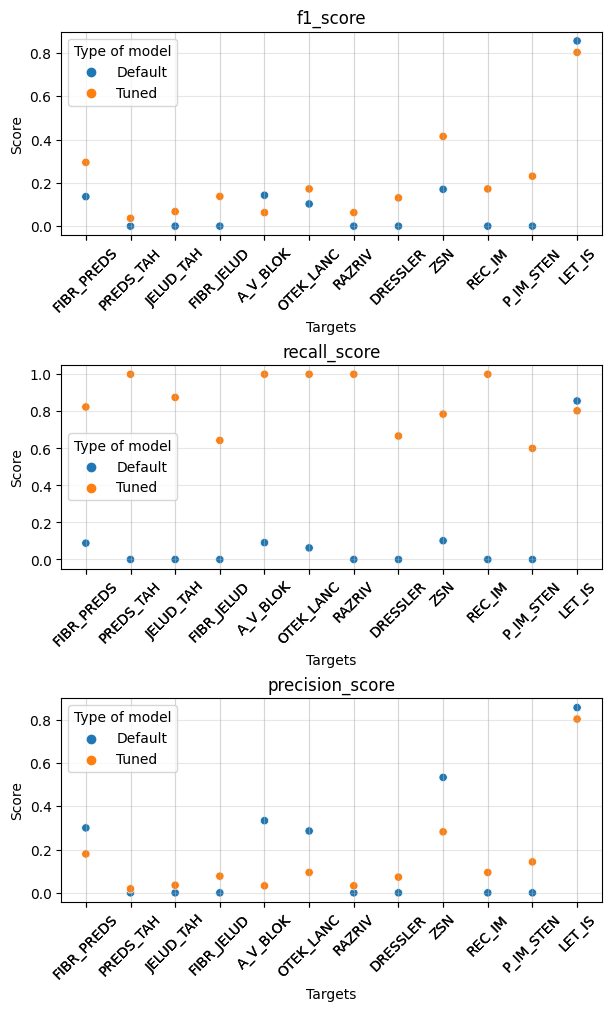

In [88]:
chosen_metrics = log_reg_scores["Metrics"].unique()
fig, axes = plt.subplots(nrows=len(chosen_metrics), ncols=1, figsize=(6, 10), constrained_layout=True)
plt.xticks(rotation=45)
for idx, metric in enumerate(chosen_metrics):
    log_reg_for_metric = log_reg_scores[log_reg_scores["Metrics"] == metric]
    sns.scatterplot(data=log_reg_for_metric, x="Targets", y="Score", hue="Type of model", ax=axes[idx])
    axes[idx].set_title(metric)
    axes[idx].set_xticks(ticks=log_reg_for_metric["Targets"], labels=log_reg_for_metric["Targets"], rotation=45)
    axes[idx].grid(alpha=0.3)
plt.show()

It's noticable how __high Recall__ score has become. Although we lost some Precision (on targets `FIBR_PREDS`, `A_V_BLOK`, `ZSN`), it's better to have more Recall in the sitation with such a dataset. One inclusion from this is final non-binary target `LET_IS` - as one can understand from the plots, target is better predicted with the default Logistic Regression model.

Let's now save the best scores for __Recall__ and __F1-score__ for Logistic Regression for every target.

In [101]:
log_reg_best_scores = {target: {} for target in target_columns}
log_reg_scores = log_reg_scores.sort_values(by="Score", ascending=False)
for target in target_columns:
    scores_for_target = log_reg_scores[log_reg_scores["Targets"] == target]
    scores_for_recall = scores_for_target[scores_for_target["Metrics"] == "recall_score"]
    scores_for_f1 = scores_for_target[scores_for_target["Metrics"] == "f1_score"]
    log_reg_best_scores[target]["recall"] = scores_for_recall["Score"].iloc[0]
    log_reg_best_scores[target]["f1_score"] = scores_for_f1["Score"].iloc[0]

In [103]:
pd.DataFrame(log_reg_best_scores)

,FIBR_PREDS,PREDS_TAH,JELUD_TAH,FIBR_JELUD,A_V_BLOK,OTEK_LANC,RAZRIV,DRESSLER,ZSN,REC_IM,P_IM_STEN,LET_IS
recall,0.823529,1.000000,0.875000,0.642857,1.000000,1.000000,1.000000,0.666667,0.784810,1.000000,0.600000,0.855882
f1_score,0.294737,0.036199,0.067308,0.137405,0.142857,0.172043,0.062678,0.130719,0.414716,0.172043,0.230769,0.855882


### Bagging Models

We'll use __Random Forest__ for the task.

In [105]:
from sklearn.ensemble import RandomForestClassifier

In [111]:
for target in target_columns:
    X_train, X_eval, y_train, y_eval = train_test_split(
        X, infarction_df[target], test_size=0.2, stratify=infarction_df[target], random_state=SEED
    )
    std_forest = RandomForestClassifier(random_state=SEED)
    std_forest.fit(X_train, y_train)
    if target != "LET_IS":
        average = "binary"
    else:
        average = "micro"    
    calculate_scores(
            y_eval,
            std_forest.predict(X_eval),
            [f1_score, recall_score, precision_score],
            target,
            average_method=average
    )

Target = FIBR_PREDS
FIBR_PREDS - f1_score:  0.0
FIBR_PREDS - recall_score:  0.0
FIBR_PREDS - precision_score:  0.0
Target = PREDS_TAH
PREDS_TAH - f1_score:  0.0
PREDS_TAH - recall_score:  0.0
PREDS_TAH - precision_score:  0.0
Target = JELUD_TAH
JELUD_TAH - f1_score:  0.0
JELUD_TAH - recall_score:  0.0
JELUD_TAH - precision_score:  0.0
Target = FIBR_JELUD
FIBR_JELUD - f1_score:  0.0
FIBR_JELUD - recall_score:  0.0
FIBR_JELUD - precision_score:  0.0
Target = A_V_BLOK
A_V_BLOK - f1_score:  0.0
A_V_BLOK - recall_score:  0.0
A_V_BLOK - precision_score:  0.0
Target = OTEK_LANC
OTEK_LANC - f1_score:  0.0
OTEK_LANC - recall_score:  0.0
OTEK_LANC - precision_score:  0.0
Target = RAZRIV
RAZRIV - f1_score:  0.0
RAZRIV - recall_score:  0.0
RAZRIV - precision_score:  0.0
Target = DRESSLER
DRESSLER - f1_score:  0.0
DRESSLER - recall_score:  0.0
DRESSLER - precision_score:  0.0
Target = ZSN
ZSN - f1_score:  0.4151
ZSN - recall_score:  0.2785
ZSN - precision_score:  0.8148
Target = REC_IM
REC_IM - f1_

### Boosting Models

We'll use __Gradient Boosting__ model from __CatBoost__ as one of the most efficient gradient boosting models.

In [112]:
from catboost import CatBoostClassifier

In [113]:
for target in target_columns:
    X_train, X_eval, y_train, y_eval = train_test_split(
        X, infarction_df[target], test_size=0.2, stratify=infarction_df[target], random_state=SEED
    )
    std_boost = CatBoostClassifier(random_state=SEED, verbose=False)
    std_boost.fit(X_train, y_train)
    if target != "LET_IS":
        average = "binary"
    else:
        average = "micro"    
    calculate_scores(
            y_eval,
            std_boost.predict(X_eval),
            [f1_score, recall_score, precision_score],
            target,
            average_method=average
    )

Target = FIBR_PREDS
FIBR_PREDS - f1_score:  0.1053
FIBR_PREDS - recall_score:  0.0588
FIBR_PREDS - precision_score:  0.5
Target = PREDS_TAH
PREDS_TAH - f1_score:  0.0
PREDS_TAH - recall_score:  0.0
PREDS_TAH - precision_score:  0.0
Target = JELUD_TAH
JELUD_TAH - f1_score:  0.0
JELUD_TAH - recall_score:  0.0
JELUD_TAH - precision_score:  0.0
Target = FIBR_JELUD
FIBR_JELUD - f1_score:  0.0
FIBR_JELUD - recall_score:  0.0
FIBR_JELUD - precision_score:  0.0
Target = A_V_BLOK
A_V_BLOK - f1_score:  0.0
A_V_BLOK - recall_score:  0.0
A_V_BLOK - precision_score:  0.0
Target = OTEK_LANC
OTEK_LANC - f1_score:  0.1053
OTEK_LANC - recall_score:  0.0625
OTEK_LANC - precision_score:  0.3333
Target = RAZRIV
RAZRIV - f1_score:  0.0
RAZRIV - recall_score:  0.0
RAZRIV - precision_score:  0.0
Target = DRESSLER
DRESSLER - f1_score:  0.0
DRESSLER - recall_score:  0.0
DRESSLER - precision_score:  0.0
Target = ZSN
ZSN - f1_score:  0.4587
ZSN - recall_score:  0.3165
ZSN - precision_score:  0.8333
Target = REC_